## Fake News Detection

### Introduction
In recent years, the proliferation of fake news has become a significant challenge in the digital age, where information spreads rapidly through social media and online news platforms. Fake news refers to the deliberate publication of misinformation or hoaxes with the intent to mislead readers. The consequences of fake news are far-reaching, influencing public opinion, impacting political decisions, and undermining trust in credible news sources.

In this project we have used LSTM to detect fake news from real news. LSTM networks, a type of recurrent neural network (RNN), are particularly effective for sequential data like text due to their ability to remember long-term dependencies. In the context of fake news detection, LSTM models can capture the contextual flow of information in an article, enabling a deeper understanding of the content and better classification performance.

#### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import string
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Data

In our project, we used dataset from kaggle, source of dataset is given in the end of this cell. The news dataset is collected from various news sources during the 2020 presidential election of United States of America. True news dataset contains news like "White House, Congress prepare for talks on spending, immigration" and fake news contains news like Racist Alabama Cops Brutalize Black Boy While He Is In Handcuffs.

In [3]:
# Load fake news data from CSV
fake_data = pd.read_csv(r"Dataset/Fake.csv")

# Load true news data from CSV
true_data = pd.read_csv(r"Dataset/True.csv")


### Data Preprocessing

We have done various data preprocessing to make the dataset fit to be trained.




In [4]:
fake_data.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [5]:
true_data.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


Here the first issue as seen above in the true data contains are:
1. A reuters disclaimer that the article is a tweet
    "The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS. The opinions expressed are his own. Reuters has not edited the statements or confirmed their accuracy. @realDonaldTrump"
2. City Name and then publisher at the start
    WASHINGTON (Reuters)

In the next block, we've wrote code to remove this from the data


In [6]:
cleansed_data = []
for data in true_data.text:
    if "@realDonaldTrump : - " in data:
        cleansed_data.append(data.split("@realDonaldTrump : - ")[1])
    elif "(Reuters) -" in data:
        cleansed_data.append(data.split("(Reuters) - ")[1])
    else:
        cleansed_data.append(data)

true_data["text"] = cleansed_data
true_data.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...",The White House said on Friday it was set to k...,politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...",President Donald Trump said on Thursday he bel...,politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,While the Fake News loves to talk about my so-...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,"Together, we are MAKING AMERICA GREAT AGAIN! b...",politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,Alabama Secretary of State John Merrill said h...,politicsNews,"December 28, 2017"


In this cell, we gave label to the dataset, 1 for fake news and 0 for real news and we concatinated two dataframe into single dataframe df.

In [7]:
# Label fake news as 1 and true news as 0
fake_data['label'] = 1
true_data['label'] = 0

# Concatenate fake and true news data
df_merge = pd.concat([fake_data, true_data], ignore_index=True)

df_merge.head(10)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",1
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",1
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",1
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",1
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",1


Here we checked if our data has any empty cell.
Since the is no empty dataset, we move forward.

In [8]:
df_merge.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

Removing columns which are not required

In [9]:
df = df_merge.drop(["title", "subject","date"], axis = 1)
df.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


Creating a function to process the texts

In [10]:
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

Describing Dataset

In [11]:
df.describe()

,label
count,44898.000000
mean,0.522985
std,0.499477
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [13]:
#Check ratio of fake to real

y = df.label
print(f'Ratio of real and fake news:')
y.value_counts(normalize=True).rename({1: 'fake', 0: 'real'})

Ratio of real and fake news:


label
fake    0.522985
real    0.477015
Name: proportion, dtype: float64

In the above cell, we can see that there is little bit more dataset on fake category than real one

In [14]:
df = df.fillna('')

In [15]:
# df["title_text"] = df["title"] + df["text"]
df["body_len"] = df["text"].apply(lambda x: len(x) - x.count(" "))
df.head()

,text,label,body_len
0,Donald Trump just couldn t wish all Americans ...,1,2378
1,House Intelligence Committee Chairman Devin Nu...,1,1590
2,"On Friday, it was revealed that former Milwauk...",1,2998
3,"On Christmas day, Donald Trump announced that ...",1,2300
4,Pope Francis used his annual Christmas Day mes...,1,1913


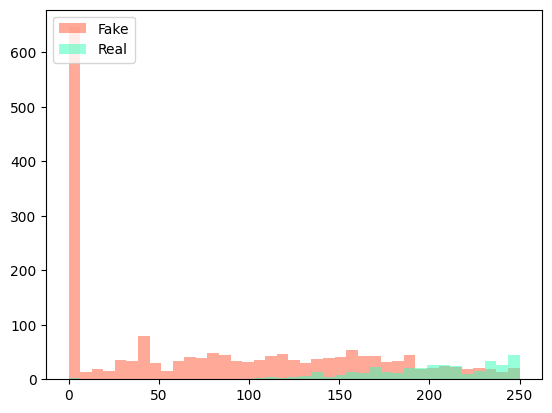

In [16]:
#Visualize fake and real news
import matplotlib.pyplot as plt

bins = np.linspace(0, 250, 40)

plt.hist(df[df["label"]== 1]["body_len"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.hist(df[df["label"]== 0]["body_len"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.legend(loc="upper left")
plt.show()

Text(0.5, 1.0, 'Distribution of Fake/Real News')

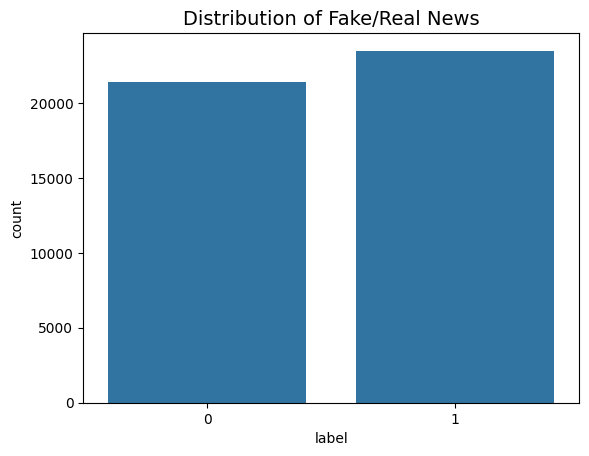

In [17]:
import seaborn as sns

class_names = ['fake', 'real']
label_count = df.label.value_counts()
sns.barplot(x=label_count.index, y=label_count)
plt.title('Distribution of Fake/Real News',fontsize =14)

Here we can see that number of real news dataset is around 20,000 and fake news dataset is more than 20,000

In [18]:
# Preprocessing
X = df['text'].astype(str)
y = df['label']


In [19]:
# Tokenization
max_features = 10000
maxlen = 100
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=maxlen)

### WordCloud

The word cloud represents the most frequent terms used in a collection of texts related to political news and discussions. Here we can see that most prominent words are "Video", "US", "Trump" and so on.

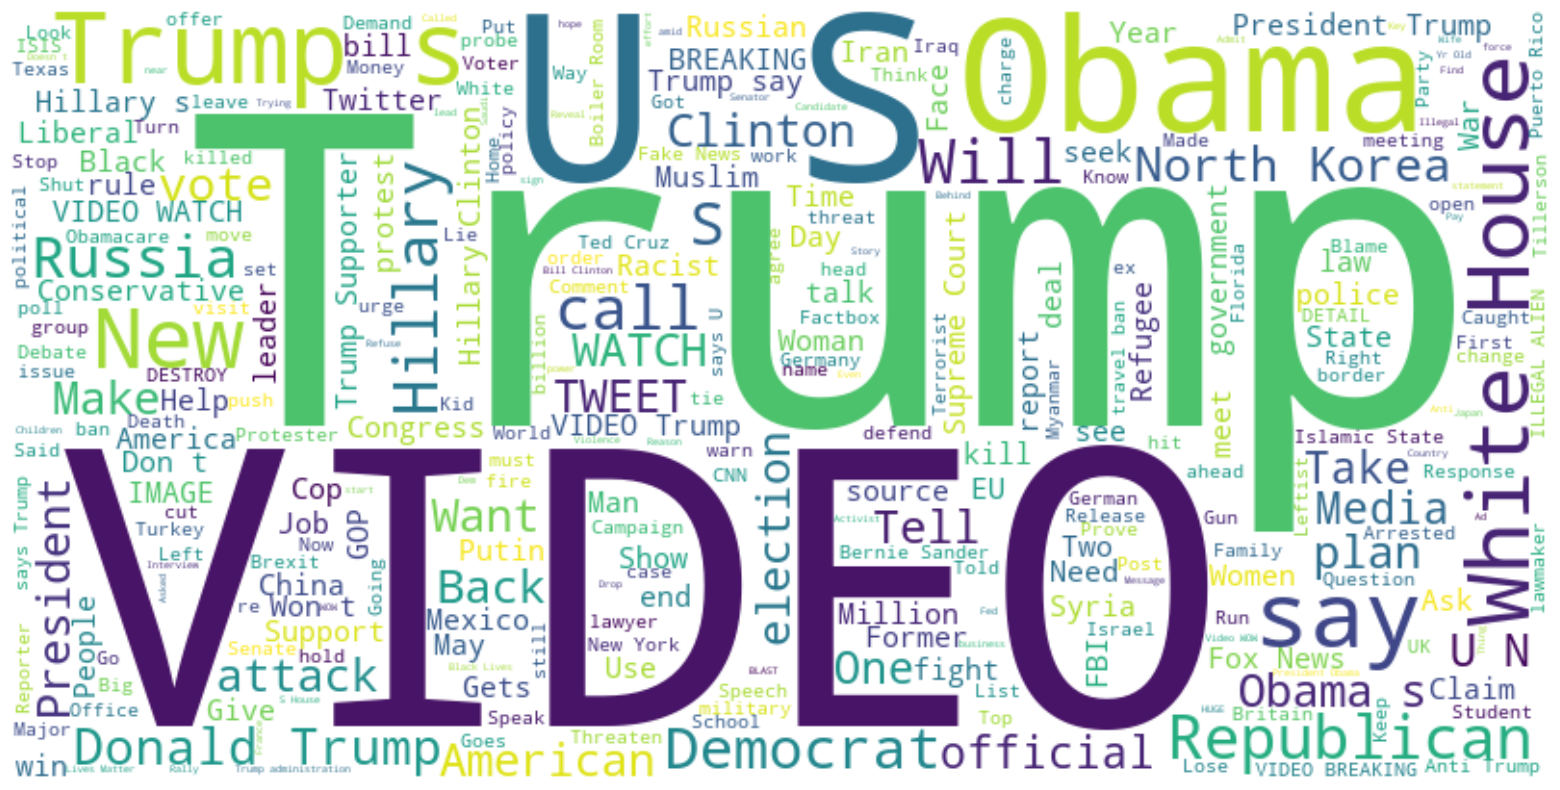

In [20]:
#Visualizing word cloud
from wordcloud import WordCloud

titles = ' '.join(title for title in df_merge['title'])
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(titles)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Scatter plot 

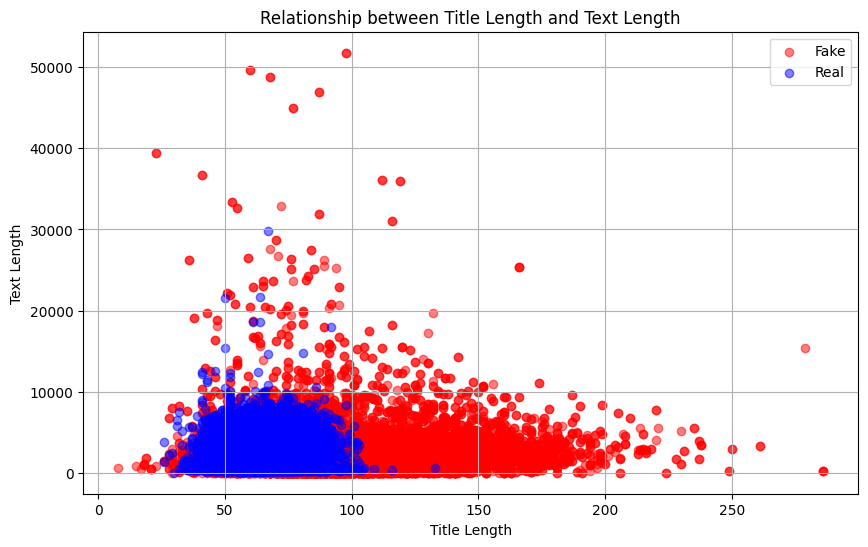

In [21]:
#Scatter Plot
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_merge[df_merge['label'] == 1]['title'].apply(len), df_merge[df_merge['label'] == 1]['text'].apply(len), label='Fake', alpha=0.5, color='red')
plt.scatter(df_merge[df_merge['label'] == 0]['title'].apply(len), df_merge[df_merge['label'] == 0]['text'].apply(len), label='Real', alpha=0.5, color='blue')
plt.title('Relationship between Title Length and Text Length')
plt.xlabel('Title Length')
plt.ylabel('Text Length')
plt.legend()
plt.grid(True)
plt.show()


From this scatter plot we can interpret that fake news has longer title length and text length than real news.

TRAIN TEST SPLIT

In [22]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Display the shape of the train and test sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (35918, 100) (35918,)
Test set shape: (8980, 100) (8980,)


### MODELING
Here we use LSTM to train the model to detect fake news. Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) particularly effective in handling sequential data, making them well-suited for fake news detection. By analyzing the temporal dependencies and contextual relationships within news articles, LSTMs can discern patterns indicative of deceptive content. These networks excel at capturing long-range dependencies and nuanced linguistic cues, allowing them to identify subtle inconsistencies and manipulative language often present in fake news. Leveraging LSTM models for fake news detection involves training on large datasets of labeled news articles to learn the characteristics that differentiate genuine news from misinformation, ultimately aiding in the automated and accurate identification of fake news.

In [24]:
# Model
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(196, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

d:\Undergraduate_Ai\Sem-5\DataMining\Mini-Project\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
# Training
batch_size = 32
epochs = 5
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)


Epoch 1/5
1123/1123 - 82s - 73ms/step - accuracy: 0.9562 - loss: 0.1241 - val_accuracy: 0.9763 - val_loss: 0.0730
Epoch 2/5
1123/1123 - 76s - 68ms/step - accuracy: 0.9758 - loss: 0.0732 - val_accuracy: 0.9781 - val_loss: 0.0682
Epoch 3/5
1123/1123 - 77s - 68ms/step - accuracy: 0.9829 - loss: 0.0520 - val_accuracy: 0.9837 - val_loss: 0.0599
Epoch 4/5
1123/1123 - 76s - 67ms/step - accuracy: 0.9904 - loss: 0.0303 - val_accuracy: 0.9844 - val_loss: 0.0527
Epoch 5/5
1123/1123 - 80s - 71ms/step - accuracy: 0.9921 - loss: 0.0229 - val_accuracy: 0.9843 - val_loss: 0.0575


## EVALUATION

In [26]:
y_pred_prob = model.predict(X_test)
y_pred = np.round(y_pred_prob).astype(int)

281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step


In the following block we calculate accuracy, precision, recall and f1 score.

In [27]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)

# Print out the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Accuracy: 0.9843
Precision: 0.9822
Recall: 0.9882
F1 Score: 0.9852


In the above cell we can see that accuracy of the model is quite good.

In the following block we display confusion matrix of the model.

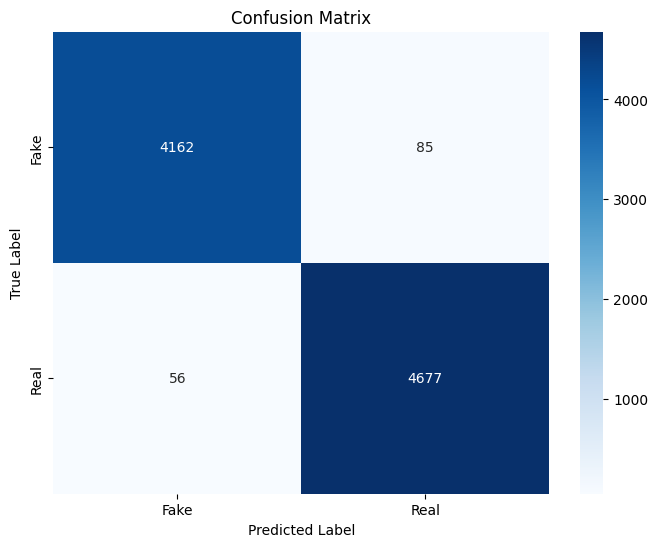

In [28]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Following code saves the model to deploy it on website

In [29]:
model.save('your_model.h5')